In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import os

In [ ]:
#### Loading:
def load_data_with_chunks(local_paths, cloud_url=None, chunk_size=10**6):
    """
    Loads data in chunks, either locally or from the cloud.
    
    Args:
        local_paths (list): Paths to local CSV files.
        cloud_url (str): Google Drive/direct download URL (optional).
        chunk_size (int): Rows per chunk.
        filter_store_ids (list): List of store_nbrs to filter by (optional).
    
    Returns:
        pd.DataFrame: Combined data or None if failed.
    """
    # 1. Attempt: Load local file (with chunking)
    for path in local_paths:
        if os.path.exists(path):
            try:
                chunks = []
                for chunk in pd.read_csv(path, chunksize=chunk_size, sep=','):
                    chunks.append(chunk)
                df = pd.concat(chunks, ignore_index=True)
                print(f"Successfully loaded local data (chunked): {path}")
                return df
            except Exception as e:
                print(f"Error loading {path}: {e}")

    # 2. Attempt: Cloud source (if URL provided)
    if cloud_url:
        try:
            file_id = cloud_url.split('/')[-2]
            download_url = f'https://drive.google.com/uc?id={file_id}'
            
            chunks = []
            for chunk in pd.read_csv(download_url, chunksize=chunk_size, sep=','):
                chunks.append(chunk)
            df = pd.concat(chunks, ignore_index=True)
            print("Successfully loaded data from cloud (chunked)")
            return df
        except Exception as e:
            print(f"Cloud download failed: {e}")

    print("No data source was available")
    return None

# Example call
store_ids = [1, 5, 10]  # Example filter
forecast_df = load_data_with_chunks(
    local_paths=['../data_forecast/forecast_df_v2.csv'],
    cloud_url='https://drive.google.com/file/d/166SQFUQ6U9RC3yO8NElJqclxaEjv_8ro/view?usp=sharing'
)

# Preliminary data analysis
print(f"Dataset size: {forecast_df.shape}")
forecast_df.head()

Successfully loaded local data (chunked): ../data/forecast_df_v2.csv
Dataset size: (313072, 4)


,date,store_nbr,item_nbr,forecast
0,2017-08-16,24,99197,0.001777
1,2017-08-17,24,99197,0.001158
2,2017-08-18,24,99197,0.004464
3,2017-08-19,24,99197,0.009184
4,2017-08-20,24,99197,0.008390



Prognosen für 5 Tage von 2017-08-16 bis 2017-08-20
        date  store_nbr  item_nbr  forecast
0 2017-08-16         24     99197  0.001777
1 2017-08-17         24     99197  0.001158
2 2017-08-18         24     99197  0.004464
3 2017-08-19         24     99197  0.009184
4 2017-08-20         24     99197  0.008390

Summierte Prognose pro Tag:
        date  total_forecast
0 2017-08-16     1525.044893
1 2017-08-17      610.686486
2 2017-08-18      479.594237
3 2017-08-19      860.989744
4 2017-08-20      190.922053


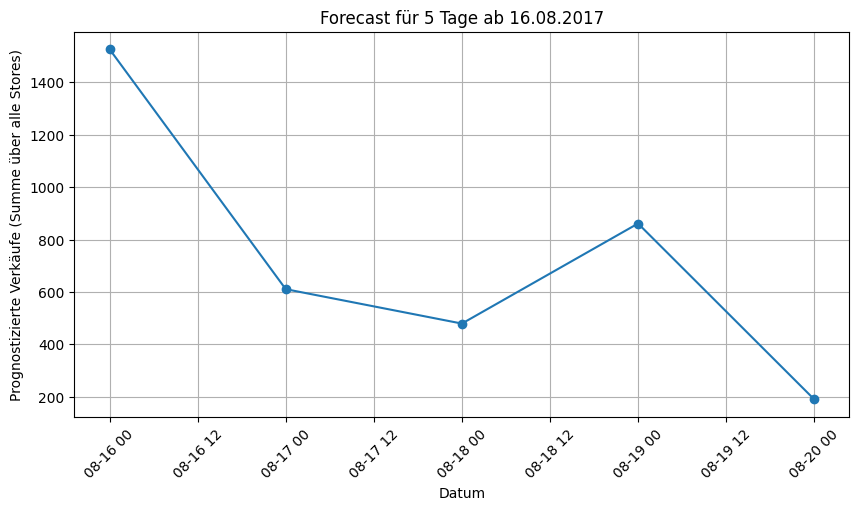


Forecast pro Store/Item:

Aggregierte Prognose pro Store/Item:
    store_nbr  item_nbr  total_forecast
0          24     99197        0.024974
1          24    103520        0.094611
2          24    105574        0.491465
3          24    105575        0.176228
4          24    105577        0.034804
5          24    105693        0.203399
6          24    105737        0.336447
7          24    105857        0.038463
8          24    106716        0.206025
9          24    108079        0.002384
10         24    108634        0.002709
11         24    108786        0.118295
12         24    108797        0.081829
13         24    108862        0.002666
14         24    108952        0.040235
15         24    111223        0.273693
16         24    111397        0.210555
17         24    112830        0.006986
18         24    114778        0.130753
19         24    114790        0.099200


In [ ]:

# -------------------------------
# 3️⃣ N-Tage Auswahl
# -------------------------------
n_days = 5  # Beispiel: 5-Tage-Vorschau
forecast_df['date'] = pd.to_datetime(forecast_df['date'])
start_date = pd.Timestamp("2017-08-16")
end_date = start_date + pd.Timedelta(days=n_days-1)

forecast_period = forecast_df[
    (forecast_df["date"] >= start_date) & (forecast_df["date"] <= end_date)
].copy()

print(f"\nPrognosen für {n_days} Tage von {start_date.date()} bis {end_date.date()}")
print(forecast_period.head())

# -------------------------------
# 4️⃣ Summierte Prognose pro Tag
# -------------------------------
agg_forecast = forecast_period.groupby("date")["forecast"].sum().reset_index()
agg_forecast.rename(columns={"forecast": "total_forecast"}, inplace=True)

print("\nSummierte Prognose pro Tag:")
print(agg_forecast)

# -------------------------------
# 5️⃣ Plot
# -------------------------------
plt.figure(figsize=(10,5))
plt.plot(agg_forecast["date"], agg_forecast["total_forecast"], marker="o", color="tab:blue")
plt.xlabel("Datum")
plt.ylabel("Prognostizierte Verkäufe (Summe über alle Stores)")
plt.title(f"Forecast für {n_days} Tage ab 16.08.2017")
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# -------------------------------
# 6️⃣ Rohdaten anzeigen
# -------------------------------
print("\nForecast pro Store/Item:")
# Gruppieren und summieren nach store_nbr und item_nbr
agg_by_store_item = (
    forecast_period
    .groupby(['store_nbr', 'item_nbr'])
    ['forecast']
    .sum()
    .reset_index()
    .rename(columns={'forecast': 'total_forecast'})
    .sort_values(['store_nbr','item_nbr'])
)

print("\nAggregierte Prognose pro Store/Item:")
print(agg_by_store_item.head()) 